In [6]:
#use Database C2DB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from pathlib import Path

from ase.db import connect
import ase.io
import jarvis_atoms
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
from jarvis.core.atoms import Atoms
from jarvis.core.atoms import pmg_to_atoms

count1 = 0
count2 = 0

missing = 0
uid = []
file_path = []
evac = []
lgnum = []
atoms = []
elastic_tensor = []
label = []
# Example usage
path0 = Path('../data/c2db 3')
for path in path0.glob('A*/*/*'):
    count1 += 1
    try:
        # Construct the path to the data.json file
        xyz_file = path / 'structure.xyz'
        if xyz_file.exists():
            structure_temp = read(xyz_file)
            structure_c2 = AseAtomsAdaptor.get_structure(structure_temp)
            Atom = pmg_to_atoms(structure_c2)

        data_file = path / 'data.json'
        # Check if the file exists before reading
        if data_file.exists():
            # Load the JSON data
            data = json.loads(data_file.read_text())

        #record if hse and stiffness json file exist
        hse_file = path / 'hse.json'
        ela_file = path / 'results-asr.stiffness.json'
        #if hse_file.exists() and ela_file.exists() and data["dyn_stab"] != 'No':
        if ela_file.exists() and data["dyn_stab"] != 'No':
            uid_temp = data['uid']
            evac_temp = data['evac']
            lgnum_temp = data['lgnum']
            ela_data = json.loads(ela_file.read_text())
            elastic_tensor_temp = ela_data['kwargs']['data']
            uid.append(uid_temp)
            evac.append(evac_temp)
            lgnum.append(lgnum_temp)
            file_path.append(path)
            atoms.append(Atom)
            elastic_tensor.append(elastic_tensor_temp)
            count2 += 1
            if 'label' in data:
                label.append(data['label'])
            else:
                label.append('na')
    except:
        #print('beep')
        missing += 1

d = {'uid':uid,'file_path':file_path,'evac':evac,'lgnum':lgnum,'atoms':atoms,'elastic_tensor':elastic_tensor,'label':label}
df0 = pd.DataFrame(data=d)

### make initial matches use pymatgen (fast)

In [ ]:
#use pymatgen to accelerate the matching
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.analysis.interfaces import ZSLGenerator
from pymatgen.analysis.interfaces import ZSLMatch
#compare systems one by one to see if they are matched
#store matching information in a new dataframe 
N = len(df0)
#tolerable mismatch
Mis = 0.05
original_id = []
mismatch = []
min_mis = []
lat_const = []
Tsuperlat = []
num_id = []
for i in range(N):
    if divmod(i,100)[1] == 0 and i > 1:
        print('complete', 100 * divmod(i,100)[0], 'steps')
    for j in range(i+1,N):
        try:
            a1 = np.real(df0.iloc[i]['atoms'].lattice_mat)[0]
            a2 = np.real(df0.iloc[i]['atoms'].lattice_mat)[1]
            b1 = np.real(df0.iloc[j]['atoms'].lattice_mat)[0]
            b2 = np.real(df0.iloc[j]['atoms'].lattice_mat)[1]
            subs = df0.iloc[i]['atoms']
            film = df0.iloc[j]['atoms']
            natom1 = subs.num_atoms
            natom2 = film.num_atoms
            if natom1 + natom2 < 11:
                film_area = np.linalg.norm(np.cross(a1,a2))
                substrate_area = np.linalg.norm(np.cross(b1,b2))
                Max_area = 1.1 * min(film_area,substrate_area)#for one to one matching
                Match_gen = ZSLGenerator(max_area_ratio_tol= 2 * Mis * Mis, max_area=Max_area, max_length_tol=Mis, max_angle_tol=0.001)
                transformation = Match_gen.generate_sl_transformation_sets(film_area, substrate_area)
                film_vectors = np.array([a1,a2])
                substrate_vectors = np.array([b1,b2])
                supercells_temp = Match_gen.get_equiv_transformations(transformation, film_vectors, substrate_vectors)
                do_it_once = 0
                Tsuperlat_temp = []
                mismatch_temp = []
                indicator = 0
                for matches in supercells_temp:
                    #only record the two smallest superlattices
                    indicator += 1
                    if indicator < 3:
                        #get superlattice info
                        film_sl_vectors = matches[0]
                        substrate_sl_vectors = matches[1]
                        film_transformation = matches[2]
                        substrate_transformation = matches[3]
                        length_mis = (np.linalg.norm(film_sl_vectors[0]) - np.linalg.norm(substrate_sl_vectors[0]))/np.linalg.norm(film_sl_vectors[0])
                        #calculate other match information
                        #Match0 = ZSLMatch(film_sl_vectors, substrate_sl_vectors, film_vectors, substrate_vectors, film_transformation, substrate_transformation)
                        #Tsuperlat_temp.append([film_transformation, substrate_transformation])
                        #mismatch_temp.append(f"{length_mis:.5f}")
                        #record information for a pair
                        if do_it_once == 0:
                            ori_id1 = df0.iloc[i]['uid']
                            ori_id2 = df0.iloc[j]['uid']
                            num_id.append([i,j])
                            original_id.append([ori_id1,ori_id2])
                            do_it_once = 1
                        #    min_mis_temp = min(mismatch_temp)
                        #    Tsuperlat.append(Tsuperlat_temp)
                            #mismatch.append(mismatch_temp)
                            #min_mis.append(min_mis_temp)
                            #lat_const_temp = [f"{np.linalg.norm(a1):.5f}",f"{np.linalg.norm(b1):.5f}"]
                            #lat_const.append(lat_const_temp)
                #if do_it_once == 1:
                    #min_mis_temp = min(mismatch_temp)
                    #Tsuperlat.append(Tsuperlat_temp)
                    #mismatch.append(mismatch_temp)
                    #min_mis.append(min_mis_temp)
                    #lat_const_temp = [f"{np.linalg.norm(a1):.5f}",f"{np.linalg.norm(b1):.5f}"]
                    #lat_const.append(lat_const_temp)
        except:
            pass

d = {'original_id':original_id,'number ID':num_id}
mat_df = pd.DataFrame(data=d)

### make initial matches use jarvis-tools (slow)

In [ ]:
import os
from jarvis.io.vasp.inputs import Poscar
#from jarvis.analysis.interface.zur import make_interface
from jarvis_interface import make_interface, ZSLGenerator
import jarvis_interface
count1 = 0
count2 = 0
original_id = []
mismatch = []
num_id = []
elastic_energy = []
N = len(df0)
for i in range(N):
    if divmod(i,500)[1] == 0 and i > 1:
        print('complete', 500 * divmod(i,500)[0], 'steps')
    for j in range(i+1,N):
        mat1 = df0.iloc[i]
        mat2 = df0.iloc[j]
        subs = mat1['atoms']
        film = mat2['atoms']
        try:
            hetero = make_interface(film=film, subs=subs, seperation = 2.5,vacuum = 15)
            hetatoms = hetero['interface'].num_atoms
            if hetero['mismatch_angle'] < 0.002 and hetatoms == natom1+ natom2 and hetatoms < 11 and abs(hetero['mismatch_u'])<0.01 and abs(hetero['mismatch_v'])<0.01:
                count +=1
                num_id.append([i,j])
                original_id.append([uid1,uid2])
                mismatch.append([abs(hetero['mismatch_u']),abs(hetero['mismatch_v'])])
                try:
                    # make interface using equilibrium position under elasticity
                    lat1sm = hetero['subs_sl'].lattice_mat
                    lat2sm = hetero['film_sl'].lattice_mat
                    C1 = mat1['elastic_tensor']
                    C2 = mat2['elastic_tensor']
                    ratio_min, ela_energy, Strain_u1, Strain_u2, Strain_v1, Strain_v2 = Elastic.elastic(lat1sm,lat2sm,C1,C2)
                    Strain_1 = [Strain_u1,Strain_u2,0.]
                    Strain_2 = [Strain_v1,Strain_v2,0.]
                    # compute area of the strained unit cell
                    area = np.linalg.norm(np.cross((1 + Strain_u1) * lat1sm[0],(1 + Strain_u2)*lat1sm[1]))
                    ela_en_per_uc = ela_energy * area/1.6 * 1e-1 
                    elastic_energy.append(ela_en_per_uc)
                except Exception as error1:
                    elastic_energy.append(999)
                    print(error1)
                    print([i,j])

        except:
            pass
d = {'original_id':original_id,'number ID':num_id, 'elastic_energy': elastic_energy}
mat_df = pd.DataFrame(data=d)

In [ ]:
d = {'original_id':original_id,'number ID':num_id, 'trsf_superlat':Tsuperlat}
mat_df = pd.DataFrame(data=d)
# Define the file path and name
file_path = './c2db_01_step.xlsx'

# Output the DataFrame to an Excel file
mat_df.to_excel(file_path, index=False)

# Make interface and write poscar 

### Make interface

In [ ]:
import ast
import Elastic
path_pairs = 'c2db_01_step.xlsx'
mat_df = pd.read_excel(path_pairs)
#get matched pairs from previous cell as a result of pymatgen algorithm (it saves time)
N = mat_df.shape[0]
count1 = 0
count2 = 0
original_id = []
mismatch = []
mis_count = []
elastic_energy = []
number_id = []
for i in range(int(N)):
    #if divmod(i,500)[1] == 0 and i > 1:
        #print('complete', 500 * divmod(i,500)[0], 'steps') 
    id1 = ast.literal_eval(mat_df.iloc[i]['number ID'])[0]
    id2 = ast.literal_eval(mat_df.iloc[i]['number ID'])[1]
    mat1 = df0.iloc[id1]
    mat2 = df0.iloc[id2]
    uid1 = mat1['uid']
    uid2 = mat2['uid']
    subs = mat1['atoms']
    film = mat2['atoms']
    natom1 = subs.num_atoms
    natom2 = film.num_atoms
    num_id = mat_df.iloc[i]['number ID']
    if 'janus' not in mat1['label'] and 'janus' not in mat2['label']:
        try:
            hetero = make_interface(film=film, subs=subs, seperation = 2.5,vacuum = 15)
            hetatoms = hetero['interface'].num_atoms
            count1 +=1
            if hetero['mismatch_angle'] < 0.002 and hetatoms == natom1 + natom2 and hetatoms < 11 and abs(hetero['mismatch_u'])<0.05 and abs(hetero['mismatch_v'])<0.05:
                original_id.append([uid1,uid2])
                number_id.append(num_id)
                mismatch.append([abs(hetero['mismatch_u']),abs(hetero['mismatch_v'])])
                count2 += 1
                try:
                    #make interface using equilibrium position under elasticity
                    lat1sm = hetero['subs_sl'].lattice_mat
                    lat2sm = hetero['film_sl'].lattice_mat
                    C1 = elastic_tensor(mat1['elastic_tensor'])
                    C2 = elastic_tensor(mat2['elastic_tensor'])
                    ratio_min, ela_energy, Strain_u1, Strain_u2, Strain_v1, Strain_v2 = Elastic.elastic(lat1sm,lat2sm,C1,C2)
                    Strain_1 = [Strain_u1,Strain_u2,0.]
                    Strain_2 = [Strain_v1,Strain_v2,0.]
                    #compute area of the strained unit cell
                    area = np.linalg.norm(np.cross((1 + Strain_u1) * lat1sm[0],(1 + Strain_u2)*lat1sm[1]))
                    ela_en_per_uc = ela_energy * area/1.6 * 1e-1 
                    elastic_energy.append(ela_en_per_uc)
                except Exception as error1:
                    elastic_energy.append(999)
                    print(error1)
                    print(id1,id2)
        
        except Exception as error:
            print(error)

d = {'original_id':original_id,'number ID': number_id, 'mismatch':mismatch,'elastic_energy':elastic_energy}
mat_df_ela = pd.DataFrame(data=d)

cannot access local variable 'v1_n' where it is not associated with a value
120 4541
cannot access local variable 'v1_n' where it is not associated with a value
127 4525
cannot access local variable 'v1_n' where it is not associated with a value
127 5021


/home/yihao/LM_code/hetero_proj/c2db/jarvis_interface.py:21: RuntimeWarning: invalid value encountered in scalar divide
  strain_y = (top.lattice_mat[1][1] - bottom.lattice_mat[1][1]) / bottom.lattice_mat[
/home/yihao/LM_code/hetero_proj/c2db/jarvis_interface.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  strain_y = (top.lattice_mat[1][1] - bottom.lattice_mat[1][1]) / bottom.lattice_mat[


cannot access local variable 'vf1' where it is not associated with a value
225 3399
cannot access local variable 'vf1' where it is not associated with a value
234 737
cannot access local variable 'vf1' where it is not associated with a value
234 3399
cannot access local variable 'v1_n' where it is not associated with a value
260 2438
cannot access local variable 'v1_n' where it is not associated with a value
260 2448
cannot access local variable 'v1_n' where it is not associated with a value
260 2449
cannot access local variable 'v1_n' where it is not associated with a value
260 2545
cannot access local variable 'v1_n' where it is not associated with a value
260 2789
cannot access local variable 'v1_n' where it is not associated with a value
260 2806
cannot access local variable 'vf1' where it is not associated with a value
263 2814
cannot access local variable 'vf1' where it is not associated with a value
279 297
cannot access local variable 'vf1' where it is not associated with a val

/home/yihao/LM_code/hetero_proj/c2db/jarvis_interface.py:18: RuntimeWarning: invalid value encountered in scalar divide
  strain_x = (top.lattice_mat[0][0] - bottom.lattice_mat[0][0]) / bottom.lattice_mat[
/home/yihao/LM_code/hetero_proj/c2db/jarvis_interface.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  strain_x = (top.lattice_mat[0][0] - bottom.lattice_mat[0][0]) / bottom.lattice_mat[


cannot access local variable 'v1_n' where it is not associated with a value
317 342


In [17]:
#order the mat_df with respect to mismatch
mat_sorted = mat_df_ela.sort_values(by='elastic_energy')
mat_new = mat_sorted[['original_id','number ID','mismatch','elastic_energy']]

# Define the file path and name
file_path = './c2db_step02.xlsx'

# Output the DataFrame to an Excel file
mat_new.to_excel(file_path, index=False)

print(f"DataFrame has been written to {file_path}")

DataFrame has been written to ./c2db_step02.xlsx


### Align and apply symmetry operators, then write POSACR file

In [ ]:
import ast
import heterostructure
import Elastic
from jarvis_interface import make_interface
file_path = './c2db_step02.xlsx'
mat_df_read = pd.read_excel(file_path)
N = len(mat_df_read)
count = 0
original_id1 = []
original_id2 = []
mismatch = []
elastic_energy = []
for i in range(N):
    if divmod(i, 500)[1] == 0 and i > 1:
        print("complete", 500 * divmod(i, 500)[0], "steps")
    pair = mat_df_read.iloc[i]
    uid = pair["original_id"]
    uid1 = uid.split("'")[1]
    uid2 = uid.split("'")[3]
    mat1 = df0[df0["uid"] == uid1].iloc[0]
    mat2 = df0[df0["uid"] == uid2].iloc[0]
    subs = mat1["atoms"]
    film = mat2["atoms"]
    ela_energy_pre = pair["elastic_energy"]
    natom1 = subs.num_atoms
    natom2 = film.num_atoms
    try:
        hetero = make_interface(film=film, subs=subs, seperation=2.5, vacuum=20)
        hetatoms = hetero["interface"].num_atoms
        if ela_energy_pre < 0.01922:

            # make interface using equilibrium position under elasticity
            lat1sm = hetero["subs_sl"].lattice_mat
            lat2sm = hetero["film_sl"].lattice_mat
            C1 = heterostructure.elastic_tensor(mat1["elastic_tensor"])
            C2 = heterostructure.elastic_tensor(mat2["elastic_tensor"])
            (
                ratio_min,
                ela_energy,
                Strain_u1,
                Strain_u2,
                Strain_v1,
                Strain_v2,
            ) = Elastic.elastic(lat1sm, lat2sm, C1, C2)
            Strain_1 = [Strain_u1, Strain_u2, 0.0]
            Strain_2 = [Strain_v1, Strain_v2, 0.0]
            # compute area of the strained unit cell
            elastic_energy.append(ela_energy_pre)
            # strain the lattice and preserve fractional coordinates
            film_eq = film.strain_atoms(Strain_2)
            subs_eq = subs.strain_atoms(Strain_1)
            film_eq.frac_coords = film.frac_coords
            subs_eq.frac_coords = subs.frac_coords
            film_eq.cart_coords = film_eq.lattice.cart_coords(film_eq.frac_coords)
            subs_eq.cart_coords = subs_eq.lattice.cart_coords(subs_eq.frac_coords)
            original_id1.append(uid1)
            original_id2.append(uid2)
            mismatch.append([abs(hetero["mismatch_u"]), abs(hetero["mismatch_v"])])
            # Rot_Center computes translation vector (after putting center of mass on the origin)
            # to make atoms on corresponding maximal wyckoff positions with rotation center at the origin
            # apply flipping first
            R_film, R_subs = heterostructure.Rot_Center(film_eq, subs_eq, 0, 0)
            film_eq = film_eq.center_around_origin(R_film)
            subs_eq = subs_eq.center_around_origin(R_subs)
            film_flipped_list = heterostructure.Apply_flipping(film_eq)
            subs_flipped_list = heterostructure.Apply_flipping(subs_eq)
            heter_atom = []

            for film_temp_flip in film_flipped_list:
                heter_atom_temp1 = []
                for subs_temp_flip in subs_flipped_list:
                    film_eq_list = heterostructure.Apply_Rotation(film_temp_flip)
                    heter_atom_temp0 = []
                    for ind_film, film_temp in enumerate(film_eq_list):
                        # Compute the displacement of center of mass to make the alignment of corresponding maximal wyckoff positions
                        # DISPLACEMENT_wyckoff(film,subs,wyckoff_indices_film,wyckoff_indices_substrate) output displacement
                        # (fractional coordinates with respect to substrate lattice
                        # Displacement_list = DISPLACEMENT_wyckoff_list(film_temp,subs_temp_flip, 0, 0)
                        # compute translation
                        t_list = heterostructure.Translation_List(
                            film_temp, subs_temp_flip
                        )
                        # make heterostructure from translation

                        # for Displacement in Displacement_list:
                        #    heter_atom_temp0 = []
                        #    het_list_before_check = Make_Het_Translation(film_temp,subs_temp_flip,t_list, Displacement, seperation=3,vacuum=20)
                        Displacement = np.array([0.0, 0.0, 0.0])
                        het_list_before_check = heterostructure.Make_Het_Translation(
                            film_temp,
                            subs_temp_flip,
                            R_film,
                            R_subs,
                            t_list,
                            Displacement,
                            seperation=3,
                            vacuum=20,
                        )
                        het_list_before_check = heterostructure.exclude_duplicate(
                            het_list_before_check
                        )
                        for het_temp in het_list_before_check:
                            heter_atom_temp0.append(het_temp)
                    heter_atom_temp0 = heterostructure.exclude_duplicate(
                        heter_atom_temp0
                    )
                    for het in heter_atom_temp0:
                        heter_atom_temp1.append(het)
                heter_atom_temp1 = heterostructure.exclude_duplicate(heter_atom_temp1)
                for het in heter_atom_temp1:
                    heter_atom.append(het)

            # check redundency
            heter_atom1 = heterostructure.exclude_duplicate(heter_atom)
            # fine-selection of vdW gap
            heter_vdw = heterostructure.gap_adjust(heter_atom1, R_film, R_subs)
            # save heterostructure to Poscar file
            layers = [uid1.split("-")[0], uid2.split("-")[0]]
            ind_mono = [uid1.split("-")[1], uid2.split("-")[1]]
            count += len(heter_atom1)
            for j, het in enumerate(heter_vdw):
                # if j % 5 == 2:
                het_atom = het["interface"].center_around_origin()
                # ind_2 = chr(97 + j % 5)
                ind_1 = str(int(j))
                Poscar(het_atom).write_file(
                    "./het_poscar/POSCAR_"
                    + layers[0]
                    + "_"
                    + ind_mono[0]
                    + "_"
                    + layers[1]
                    + "_"
                    + ind_mono[1]
                    + "_"
                    + ind_1
                    + ".vasp"
                )
        # Poscar(subs).write_file('/Users/user/Documents/pycode/Lattice matching/data/c2db_monolayer_poscar/POSCAR_'+layers[0]+'-'+ind_mono[0]+'.vasp')
        # Poscar(film).write_file('/Users/user/Documents/pycode/Lattice matching/data/c2db_monolayer_poscar/POSCAR_'+layers[1]+'-'+ind_mono[1]+'.vasp')

    except Exception as error:
        print(error)

d = {
    "original_id1": original_id1,
    "original_id2": original_id2,
    "mismatch": mismatch,
    "elastic_energy": elastic_energy,
}
mat_df_fine = pd.DataFrame(data=d)


# Define the file path and name
file_path = "./c2db_used_pairs.xlsx"
# Output the DataFrame to an Excel file
mat_df_fine.to_excel(file_path, index=False)

print(f"DataFrame has been written to {file_path}")

In [17]:
#produce list of monolayer according to matched pair ranking
mono_list = []
for i in range(len(mat_df_fine)):
    if divmod(i,500)[1] == 0 and i > 1:
        print('complete', 500 * divmod(i,500)[0], 'steps')
    pair = mat_df_fine.iloc[i]
    uid1 = pair['original_id1']
    uid2 = pair['original_id2']
    if uid1 not in mono_list:
        mono_list.append(uid1)
    if uid2 not in mono_list:
        mono_list.append(uid2)

with open("c2db_mono_list.txt", "w") as file:
    for item in mono_list:
        file.write(str(item) + "\n")

### Statistics on generated structures

In [58]:
triclinic = np.arange(1,3)
monoclinic_inc = np.arange(3,8)
monoclinic_orth = np.arange(8,19)
orthorhombic = np.arange(19,49)
tetragonal = np.arange(49,65)
trigonal = np.arange(65,73)
hexagonal = np.arange(73,81)
lg_types = [monoclinic_orth, orthorhombic, tetragonal, trigonal, hexagonal]
lg_types_names = ['monoclinic', 'orthorhombic', 'tetragonal', 'trigonal', 'hexagonal']
lg_num_counts = np.zeros((80,80))

In [59]:
#statistics on the number of heterostructures
import glob
num_nonhex_pair = 0
num_nonhex_het = 0
nonhex_het_list = []
num_diff_types = 0
type_stat_mat = np.full((len(lg_types),len(lg_types)),0,dtype=int)
mat_df_fine = pd.read_excel('c2db_used_pairs.xlsx')
uids = []
for i, mat in mat_df_fine.iterrows():
    #get symmetry group of film and substrate
    uid1 = mat['original_id1']
    uid2 = mat['original_id2']
    #if uid1 not in uids:
    #    uids.append(uid1)
    #if uid2 not in uids:
    #    uids.append(uid2)
    lgnum1 = df0[df0['uid']==uid1].lgnum.values[0]
    lgnum2 = df0[df0['uid']==uid2].lgnum.values[0]
    if lgnum1 == lgnum2:
        lg_num_counts[lgnum1-1,lgnum2-1] += 1
    else:
        lg_num_counts[lgnum1-1,lgnum2-1] += 1
        lg_num_counts[lgnum2-1,lgnum1-1] += 1
    '''
    if lgnum1 < 65 or lgnum2 < 65:
        num_nonhex_pair += 1
        layers = [uid1.split("-")[0], uid2.split("-")[0]]
        ind_mono = [uid1.split("-")[1], uid2.split("-")[1]]
        num_het = len(glob.glob('./het_poscar/POSCAR_'+ 
                                                        layers[0]+'_' + ind_mono[0] + '_' + layers[1] + '_' + ind_mono[1] + '_*.vasp'))
        num_nonhex_het += num_het
        mismatch = mat['mismatch']
        nonhex_het = {'uid1': uid1, 'uid2': uid2, 'layer group':[lgnum1, lgnum2], 'num_het': num_het, 'mismatch': mat['mismatch'], 'elastic_energy': mat['elastic_energy']}
        nonhex_het_list.append(nonhex_het)

    same_type = 0
    if lgnum1 != lgnum2:
        for ty in lg_types:
            if lgnum1 in ty and lgnum2 in ty:
                same_type = 1
                break
    else:
        same_type = 1
    if same_type == 0:
        num_diff_types += 1
    '''
    for i, ty in enumerate(lg_types):
        if lgnum1 in ty and lgnum2 in ty:
            type_stat_mat[i][i] += 1
            break
        else:
            for j, ty2 in enumerate(lg_types):
                if lgnum1 in ty and lgnum2 in ty2:
                    type_stat_mat[i][j] += 1
                    type_stat_mat[j][i] += 1
                    break


#print("number of pairs where two monolayers are not in same type:", num_diff_types)
#print("total number of monolayers used:", len(uids))
#print('number of non-hexagonal pairs:', num_nonhex_pair)
#print('number of non-hexagonal heterostructures:', num_nonhex_het)
#mat_non_hex_df = pd.DataFrame(nonhex_het_list)
# Define the file path and name
# file_path = './nonhex_pairs.xlsx'

# Output the DataFrame to an Excel file
#mat_non_hex_df.to_excel(file_path, index=False)

#print(f"DataFrame has been written to {file_path}")

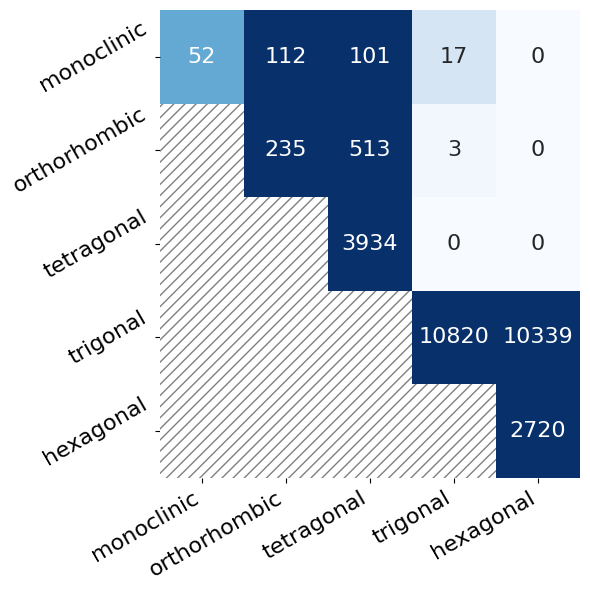

In [61]:
#make plot
import seaborn as sns
import matplotlib.patches as patches
# Create the plot
fig = plt.figure(figsize=(6, 6))
'''
rows, cols = np.nonzero(lg_num_counts)
uni_rows = np.unique(rows)
lg_non_zero = np.zeros((len(uni_rows), len(uni_rows)), dtype=int)
for i in range(len(uni_rows)):
    for j in range(len(uni_rows)):
        lg_non_zero[i, j] = lg_num_counts[uni_rows[i], uni_rows[j]]
lg_num_names = [str(i) for i in uni_rows]
'''
# Create a mask: same shape as conf_mat, all False by default
mask = np.zeros_like(type_stat_mat, dtype=bool)

for i in range(len(lg_types)):
    for j in range(len(lg_types)):
        if i > j:
            mask[i, j] = True

# Plot the heatmap
# - annot=True prints the confusion matrix numbers in each cell
# - fmt='.2f' formats the numbers to 2 decimal places
# - vmin=0, vmax=100 scales the colorbar between 0 and 100%
ax = sns.heatmap(
    type_stat_mat, 
    #lg_non_zero,
    annot=True, 
    cmap='Blues', 
    fmt='.0f', 
    xticklabels=lg_types_names, 
    yticklabels=lg_types_names,
    #xticklabels=lg_num_names, 
    #yticklabels=lg_num_names,
    mask=mask,
    vmin=0,
    vmax=100,
    annot_kws={"size": 16},
    cbar = False
)

# Get the number of rows and columns
nrows, ncols = type_stat_mat.shape

# Loop through each cell and, if the cell is masked, add a patch with a hatch pattern.
for i in range(nrows):
    for j in range(ncols):
        if mask[i, j]:
            # In a heatmap, each cell is drawn as a square with width and height 1.
            # The cell at row i, column j starts at coordinates (j, i)
            rect = patches.Rectangle(
                (j, i),             # Lower left corner of the cell
                1, 1,               # Width and height
                fill=True,          # Enable filling (even though we overlay hatching)
                hatch='///',        # Hatch pattern (diagonal lines)
                edgecolor='gray',   # Edge color for the hatch pattern lines
                facecolor='white',  # Base fill color (can be adjusted or set to 'none')
                linewidth=0,        # No extra border line (optional)
                zorder=2            # Ensure the hatches appear on top of the heatmap
            )
            ax.add_patch(rect)

#colorbar = ax.collections[0].colorbar
# Adjust the tick label font size for the legend (colorbar)
#colorbar.ax.tick_params(labelsize=14)  # Change 14 to your desired size
# Optional: if you have a label for the colorbar, set its font size too
#colorbar.set_label("Colorbar Label", fontsize=16)
# Labeling and styling
#ax.set_title(
#    "Monolayer Layer Group Types",  # Title of the plot
#    fontsize=20,
#    loc='center',  # horizontally center the title
#    pad=30         # push the title 30 points higher
#)
#ax.set_xlabel("Layer Group Types", fontsize=18)
#ax.set_ylabel("Layer Group Types", fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(False)  # Disable the grid

# To ensure the x-axis labels don't overlap
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.setp(ax.get_yticklabels(), rotation=30)

# Display the figure
plt.tight_layout()
plt.show()
fig.savefig("./stat_mono.png", dpi=300, bbox_inches='tight')

In [6]:
import spglib as spg
import itertools
from pymatgen.core import Element, Species
import glob
def get_layer_group(structure, symprec):
    unique_species: list[Element | Species] = []
    zs = []
    for species, group in itertools.groupby(structure, key=lambda s: s.species):
        if species in unique_species:
            ind = unique_species.index(species)
            zs.extend([ind + 1] * len(tuple(group)))
        else:
            unique_species.append(species)
            zs.extend([len(unique_species)] * len(tuple(group)))
    cell = (
                    tuple(map(tuple, structure.lattice.matrix.tolist())),
                    tuple(map(tuple, structure.frac_coords.tolist())),
                    tuple(zs),
                )
    layergroup_data = spg.get_layergroup(cell, symprec=symprec)
    return layergroup_data

In [32]:
#do the statistics on the number of heterostructures
mat_df_fine = pd.read_excel('c2db_used_pairs.xlsx')
het_stat = []
lg_het_count = np.zeros((80),dtype=int)
for i, mat in mat_df_fine.iterrows():
    if i % 2000 == 0:
        print('complete', i, 'steps')
    #get symmetry group of film and substrate
    uid1 = mat['original_id1']
    uid2 = mat['original_id2']
    lgnum1 = df0[df0['uid']==uid1].lgnum.values[0]
    lgnum2 = df0[df0['uid']==uid2].lgnum.values[0]
    layers = [uid1.split("-")[0], uid2.split("-")[0]]
    ind_mono = [uid1.split("-")[1], uid2.split("-")[1]]
    list_het = glob.glob('./het_poscar/POSCAR_'+ 
                                                    layers[0]+'_' + ind_mono[0] + '_' + layers[1] + '_' + ind_mono[1] + '_*.vasp')
    num_het = len(list_het)
    for het_path in list_het:
        het_atom = Structure.from_file(het_path)
        lgnum = get_layer_group(het_atom, symprec=1e-04)['number']
        lg_het_count[lgnum-1] += 1
    mismatch = mat['mismatch']
    het_info = {'uid1': uid1, 'uid2': uid2, 'layer group':[lgnum1, lgnum2], 'num_het': num_het}
    #het_stat.append(het_info)

complete 0 steps


/tmp/ipykernel_577568/1409382635.py:20: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  lgnum = get_layer_group(het_atom, symprec=1e-04)['number']


complete 2000 steps
complete 4000 steps
complete 6000 steps
complete 8000 steps
complete 10000 steps
complete 12000 steps
complete 14000 steps
complete 16000 steps
complete 18000 steps
complete 20000 steps
complete 22000 steps
complete 24000 steps
complete 26000 steps
complete 28000 steps


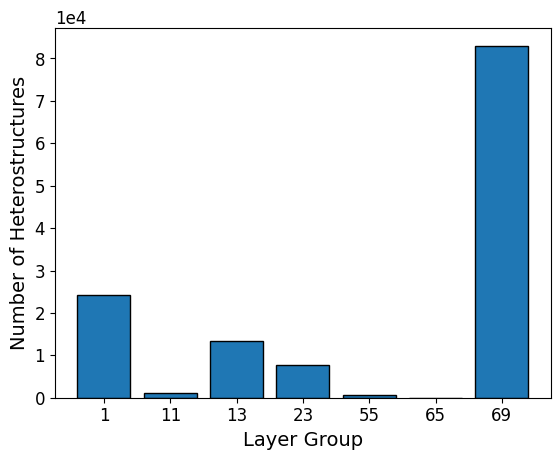

In [65]:
# Example: precomputed bin heights stored in an array.
# Each index corresponds to a bin (x-axis), and the value is the height (frequency).
non_zero_pos = np.nonzero(lg_het_count)
bin_heights = lg_het_count[non_zero_pos]
# Create an array of indices for the x-axis.
x_indices = non_zero_pos[0]
tick_positions = np.arange(len(x_indices)) 
# Create the bar plot.
fig = plt.bar(tick_positions, bin_heights, width=0.8, edgecolor='black')
# Add labels and title.
plt.xlabel('Layer Group', fontsize=14)
plt.ylabel('Number of Heterostructures', fontsize=14)
#plt.title('Distribution of Layer Group Numbers of Heterostructures', fontsize=15)

# Optionally, set the x-ticks to show every bin index.
plt.xticks(tick_positions, x_indices + 1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_fontsize(12)
plt.tick_params(labelsize=12)
plt.savefig("./dis_het.png", dpi=300, bbox_inches='tight')
# Display the plot.
plt.show()


# Band alignment

In [7]:
import os
from jarvis.io.vasp.inputs import Poscar
#from jarvis.analysis.interface.zur import make_interface
from jarvis_interface import make_interface
from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import Elastic
import pandas as pd
import numpy as np
import contextlib
import BandCrossing
# from the band structure to calculate dos 
FINGERPRINT_LENGTH = 100

def calc_all_k_branches_histogram_fingerprint(bands_dict, fingerprint_length=FINGERPRINT_LENGTH, e_range=None, normalize=False, shifted=True):

    fingerprint = np.zeros(fingerprint_length)
    
    k_points = bands_dict["bzkpts"]

    energies = np.array(bands_dict["eig_soc_mk"]).flatten()

    if e_range != None:
        bin_energy = np.linspace(e_range[0],e_range[1], num = fingerprint_length)
    else:
        bin_energy = np.linspace(min(energies),max(energies), num = fingerprint_length)

    if shifted:
        energies -= bands_dict["efermi"]

    counts, edges = np.histogram(energies, bins=fingerprint_length, range=e_range, density=normalize)

    fingerprint = {'densities':counts, 'energies': bin_energy}
    
    return fingerprint

def plot_dos_fingerprint(dos_fingerprint):
    fp = dos_fingerprint['densities']
    x = dos_fingerprint['energies']
    fig, ax = plt.subplots()
    ax.plot(x,fp)
    #ax.yaxis.set_major_locator(ticker.FixedLocator(ylocatorh))
    ax.grid(True)
    ax.set_title("dos fingerprint")
    plt.show()

def HeteroFermiCalc(mat1_dos, ef1, mat2_dos,ef2,dos_step):
    #print('Fermi of first material: ' +str(ef1)+ ';shifted Fermi of second material: '+ str(ef2))
    en_mat1 = np.array(mat1_dos['energies'])
    tdos_mat1 = np.array(mat1_dos['densities'])
    en_mat2 = np.array(mat2_dos['energies'])
    tdos_mat2 = np.array(mat2_dos['densities'])
    if ef1 < ef2:
        fermi1=ef1
        fermi2=ef2
        en1=en_mat1
        en2=en_mat2
        tdos1=tdos_mat1
        tdos2=tdos_mat2
    else:
        fermi1=ef2
        fermi2=ef1
        en1=en_mat2
        en2=en_mat1
        tdos1=tdos_mat2
        tdos2=tdos_mat1
    for num,i in enumerate(np.linspace(fermi1,fermi2,dos_step)):
        
        x1 = en1[(en1 < i) & (en1 > fermi1)]
        x2 = en2[(en2 < fermi2) & (en2 > i)]
        y1 = tdos1[(en1 < i) & (en1 > fermi1)]
        y2 = tdos2[(en2 < fermi2) & (en2 > i)]
        int1 = np.trapz(y1,x1)
        int2 = np.trapz(y2,x2)
        #print(num, int1, int2,x1,y1)
        if int1 >= int2:
            #print(f'New Fermi energy for superimposed band-structure = {i}')
            new_fermi = i
            break 
    #new_fermi = mat1_dos['efermi'] 
    return new_fermi

In [ ]:
#read band data
path_pairs = ('./c2db_step02.xlsx')
path0 = Path('../data/c2db 3')
df_pairs = pd.read_excel(path_pairs) 
pairs_overlap = []
for i in range(len(df_pairs)):
#for i in [2]:
    pair = df_pairs.iloc[i]
    uid = pair['original_id']
    uid1 = uid.split("'")[1]
    uid2 = uid.split("'")[3]
    mat1 = df0[df0['uid']==uid1].iloc[0]
    mat2 = df0[df0['uid']==uid2].iloc[0]
    bands_path1 = mat1['file_path'] / 'hse.json'
    bands_path2 = mat2['file_path'] / 'hse.json'
    
    if bands_path1.exists():
        with open(bands_path1) as f:
            bands_dict1 = json.load(f)
    if bands_path2.exists():
        with open(bands_path2) as f:
            bands_dict2 = json.load(f)
    Efermi1 = bands_dict1['efermi']
    Efermi2 = bands_dict2['efermi']
    kpoints1 = bands_dict1['bzkpts']
    kpoints2 = bands_dict2['bzkpts']
    avg_efermi = 1/2 * Efermi1 + Efermi2
    Evac1 = mat1['evac']
    Evac2 = mat2['evac']
    DelEv = Evac1 - Evac2
    dos_fingerprint1 = calc_all_k_branches_histogram_fingerprint(bands_dict1, fingerprint_length=FINGERPRINT_LENGTH, 
                                                            e_range=(avg_efermi - 8, avg_efermi + 8), normalize=False, shifted=True)
    
    dos_fingerprint2 = calc_all_k_branches_histogram_fingerprint(bands_dict2, fingerprint_length=FINGERPRINT_LENGTH, 
                                                            e_range=(avg_efermi - 8, avg_efermi + 8), normalize=False, shifted=True)

    #shift the energy array
    mat2_dosE = np.array(dos_fingerprint2['energies']) + DelEv
    shifted_dos_mat2 = {'densities': dos_fingerprint2['densities'], 'energies':mat2_dosE}
    
    new_fermi = HeteroFermiCalc(mat1_dos = dos_fingerprint1 ,ef1 = Efermi1, mat2_dos = shifted_dos_mat2 , 
                                ef2 = Efermi2+DelEv , dos_step = FINGERPRINT_LENGTH)

    overlap, overlap_index = BandCrossing.overlap_ind_kgrid(new_fermi, DelEv, bands_dict1['eig_soc_mk'],
                                                            bands_dict2['eig_soc_mk'], kpoints1, kpoints2,
                                                            en_range_width = 6, num_slices = 10, projection = False)
    pairs_overlap.append(overlap_index)

d = {'Bands Overlap': pairs_overlap}
df_overlap = pd.DataFrame(data=d)
df_pairs = pd.concat([df_pairs, df_overlap], axis=1)

In [12]:
#order the mat_df with respect to mismatch
mat_sorted = df_pairs.sort_values(by='Bands Overlap',ascending=False)
mat_new = mat_sorted[['original_id', 'number ID', 'mismatch', 'elastic_energy', 'Bands Overlap']]

# Define the file path and name
file_path = '/Users/user/Documents/pycode/Lattice matching/c2db_overlap_6ev_20Jan.xlsx'

# Output the DataFrame to an Excel file
mat_new.to_excel(file_path, index=False)

print(f"DataFrame has been written to {file_path}")

DataFrame has been written to /Users/user/Documents/pycode/Lattice matching/c2db_overlap_6ev_20Jan.xlsx


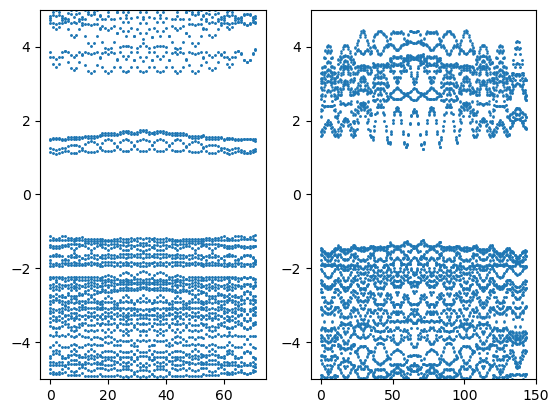

In [28]:
num_id1, num_id2 = 1223, 2837
mat1 = df0.iloc[num_id1]
mat2 = df0.iloc[num_id2]
bands_path1 = mat1['file_path'] / 'hse.json'
bands_path2 = mat2['file_path'] / 'hse.json'
if bands_path1.exists():
        with open(bands_path1) as f:
            bands_dict1 = json.load(f)
if bands_path2.exists():
    with open(bands_path2) as f:
        bands_dict2 = json.load(f)
Efermi1 = bands_dict1['efermi']
Efermi2 = bands_dict2['efermi']
#plot the band structure
en1 = []
ind1 = []
for i in range(len(bands_dict1['eig_soc_mk'])):
    for j in range(len(bands_dict1['eig_soc_mk'][i])):
        en1.append(bands_dict1['eig_soc_mk'][i][j]-Efermi1)
        ind1.append(j)
en2 = []
ind2 = []
for i in range(len(bands_dict2['eig_soc_mk'])):
    for j in range(len(bands_dict2['eig_soc_mk'][i])):
        en2.append(bands_dict2['eig_soc_mk'][i][j]-Efermi2)
        ind2.append(j)
fig, axes = plt.subplots(1,2)
axes[0].scatter(ind1,en1,s=0.7)
axes[1].scatter(ind2,en2,s=0.7)
axes[0].set_ylim(-5,5)
axes[1].set_ylim(-5,5)
plt.show()

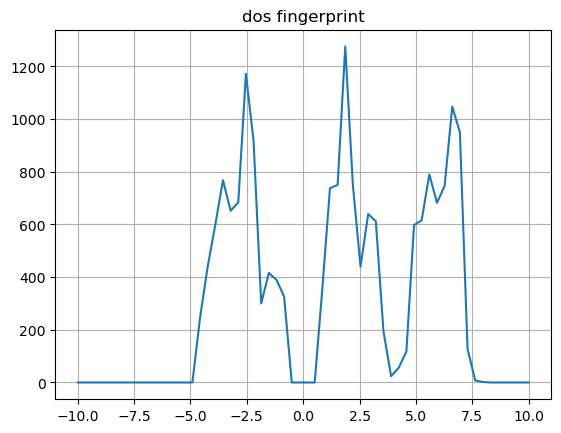

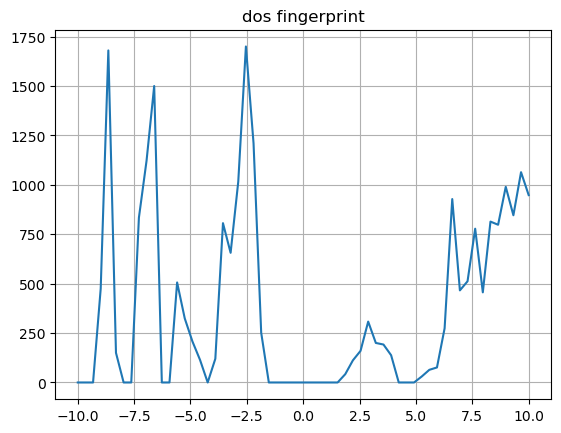

In [75]:
dos_fingerprint1 = calc_all_k_branches_histogram_fingerprint(bands_dict1, fingerprint_length=FINGERPRINT_LENGTH, 
                                                            e_range=(-10,10), normalize=False, shifted=True)
plot_dos_fingerprint(dos_fingerprint1)

dos_fingerprint2 = calc_all_k_branches_histogram_fingerprint(bands_dict2, fingerprint_length=FINGERPRINT_LENGTH, 
                                                            e_range=(-10,10), normalize=False, shifted=True)
plot_dos_fingerprint(dos_fingerprint2)

# Further screening

In [3]:
import pandas as pd
import numpy as np

In [6]:
#read list of matches
file_path = './c2db_step02.xlsx'
mat_df = pd.read_excel(file_path)

def if_janus(atom):
    if len(atom.cart_coords) == 3:
        com_z = atom.get_center_of_mass()[2]
        mid_ind = np.argsort(np.transpose(np.array(atom.cart_coords))[2])[1]
        center_atom_z = atom.cart_coords[mid_ind][2]
        thickness = np.max(atom.cart_coords[:,2]) - np.min(atom.cart_coords[:,2])
        if (com_z - center_atom_z)/thickness > 1e-2:
            return True
    return False
    

### throw away toxic and radioactive elements

In [7]:
toxic = ['As', 'Po', 'Tl', 'Hg']
radioac = ['Tc', 'Pm', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', \
           'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', \
           'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Uut', 'Fl', 'Uup', 'Lv', 'Uus', 'Uuo']
safe_mat_list = []
for i in range(len(mat_df)):
    pair = mat_df.iloc[i]
    uid = pair['original_id']
    uid1 = uid.split("'")[1]
    uid2 = uid.split("'")[3]
    if_toxic = 0
    if_radioac = 0
    for el in toxic:
        if el in uid1 or el in uid2:
            if_toxic = 1
    for el in radioac:
        if el in uid1 or el in uid2:
            if_radioac = 1
    mat1 = df0.loc[df0['uid']==uid1].iloc[0]
    mat2 = df0.loc[df0['uid']==uid2].iloc[0]
    if if_toxic or if_radioac:
        print("abandon ", uid, "for toxicity and radioactivity")
    elif 'janus' in mat1['label'] or 'janus' in mat2['label']:
        print("abandon ", uid, "for janus lattice")
    else:
        subs = mat1['atoms']
        film = mat2['atoms']
        if if_janus(subs) or if_janus(film):
            print("abandon ", uid, "for janus lattice")
        else:
            safe_mat_list.append(i)

mat_df_new = mat_df.iloc[safe_mat_list]
print("there are",len(mat_df_new), "materials left")

abandon  ['1HgCl2-2', '1TiTe2-3'] for toxicity and radioactivity
abandon  ['2NiSe-4', '1HgS2-2'] for toxicity and radioactivity
abandon  ['1SeSn-1', '1AsTe2Zr2-1'] for toxicity and radioactivity
abandon  ['1HgS2-2', '2Si-1'] for toxicity and radioactivity
abandon  ['1BiFS-1', '1GaP-1'] for janus lattice
abandon  ['1SrCl2-2', '1CdInTlSe4-1'] for toxicity and radioactivity
abandon  ['2As-1', '1KTiS2-1'] for toxicity and radioactivity
abandon  ['1ScCl2-1', '1AsS2Ti2-1'] for toxicity and radioactivity
abandon  ['1SbTe2-2', '1AsHf2Te2-1'] for toxicity and radioactivity
abandon  ['2AsCoNa-1', '1FeCl2-2'] for toxicity and radioactivity
abandon  ['1AsTe2-2', '1TaTe2-2'] for toxicity and radioactivity
abandon  ['1CdCl2-1', '1AsHf2Te2-1'] for toxicity and radioactivity
abandon  ['2OTl-2', '1CoTe2-2'] for toxicity and radioactivity
abandon  ['1AsTe2Ti2-1', '1CdClHO-1'] for toxicity and radioactivity
abandon  ['2GaSnTe-1', '1TlI2-3'] for toxicity and radioactivity
abandon  ['2AsKNi-1', '2RuTe-1'] 

### screen through overlap index and elastic energy

In [30]:
survivor = []
ela_threshold = 1e-4
#overlap_threshold = 2000 #for 6eV
overlap_threshold = 2000 #for 1eV
for i in range(len(mat_df_new)):
    pair = mat_df_new.iloc[i]
    if pair['elastic_energy'] < ela_threshold and pair['Bands Overlap'] > overlap_threshold:
        survivor.append(i)
mat_df_screened = mat_df_new.iloc[survivor]
print("there are",len(mat_df_screened), "materials left")

there are 472 materials left


In [8]:
file_path = './c2db_step3.xlsx'

# Output the DataFrame to an Excel file
mat_df_new.to_excel(file_path, index=False)

print(f"DataFrame has been written to {file_path}")

DataFrame has been written to ./c2db_step3.xlsx


# Check symmetry

In [3]:
import ast
file_path = './c2db_step3.xlsx'
mat_df = pd.read_excel(file_path)
count = 0
indices = []
lgnums = []
for i in range(len(mat_df)):
    id1 = ast.literal_eval(mat_df.iloc[i]['number ID'])[0]
    id2 = ast.literal_eval(mat_df.iloc[i]['number ID'])[1]
    mat1 = df0.iloc[id1]
    mat2 = df0.iloc[id2]

    if mat1['lgnum'] < 65 or mat2['lgnum'] < 65:
        print(mat1['uid'], mat2['uid'])
        count += 1
        indices.append(i)
        lgnums.append([mat1['lgnum'],mat2['lgnum']])
mat_df_non_hex = mat_df.iloc[indices]
mat_df_non_hex['lgnum'] = lgnums
file_path = './c2db_non_hex.xlsx'

# Output the DataFrame to an Excel file
mat_df_non_hex.to_excel(file_path, index=False)

1ReS2-3 2BrFe-1
2CaHI-1 2OPb-1
1TaO2-3 1FeMnTe2-1t
2GeNbSb-1 1FeSe2-3
2HfSiTe-1 1TaO2-3
1CoBr2-1 2ITi-1
2FeGeMg-1 2BrTi-1
1AgBa2Cl2O2-1 1HfTe2-3
1CuI2O2Sr2-1 1MnBr2-2
2BaCoGe-1 1CdCl2-2
2BaClF-1 1YS2-1
2HfSiTe-1 1FeMnTe2-1t
3BrLi-1 2FeI-1
2LiMnP-1 2FeS-1
2GeSeZr-1 1ReS2-3
2GeSeZr-1 2BrFe-1
2CaFI-1 1HfSe2-3
1ZrS2-3 1NiBr2-2
2CoNaSb-1 1FeI2-2
2FeSiSr-1 1VTe2-3
2MnSnSr-2 1CrI2-2
2FeNaP-1 2BrTi-1
1HfS2-3 1CoBr2-1
2CoLiSb-1 2RuTe-1
2RuTe-1 2ILi-3
2CoLiSb-1 2ILi-3
1MoS2-3 1CuBr2-1
2CoNaSb-1 1YS2-1
2HISr-1 1YS2-1
1NiCl2-2 2SeZn-2
1FeI2-2 1YS2-1
2BaClF-1 1FeI2-2
2FeTe-1 1Se2Zr3-1
2ClHSr-1 1FeBr2-2
2MnNaP-1 1TaS2-3
2PtSe-1 2IMn-1
1ZnBr2-1 2RhTe-3
1HfS2-3 2ITi-1
2BrNZr-3 1HfSe2-3
2FeLiSb-1 1ScBr2-3
2HLiO-1 2FeTe-1
2FeMgSi-1 1PbS2-3
2BaClH-1 1HfTe2-3
1RuS2-3 2NiTe-2
2CoSiSr-1 1ZnBr2-1
2GeHfTe-1 2CoTe-1
1RhF4-1 1ZrSe2-3
1CuCl2-2 1Se2Hf3-1
2CaClF-1 1AgO2-1
2FeKP-1 2NiS-3
2BiIn-1 2MgTe-1
2KNiP-1 1CuI2-1
2CrSe-1 2BrCr-1
2GeMgMn-1 1ScBr2-3
2BaCoSi-1 2IMn-1
1MnI2-2 2BiGa-1
1FeCl2-2 2FeI-1
1SSeFe2-1t 1F

/var/folders/hk/j1qyzlyn57x084q_wmw231fw0000gp/T/ipykernel_92554/2355865259.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat_df_non_hex['lgnum'] = lgnums


In [6]:
#check how many non-trigonal and non-hexagonal materials in c2db
print("number of non-hexagonal lattices in matched pairs:", count)
count1 = 0
for i in range(len(df0)):
    mat = df0.iloc[i]
    if mat['lgnum'] < 65:
        count1 += 1
print("number of non-hexagonal lattices in c2db:", count1)

number of non-hexagonal lattices in matched pairs: 788
number of non-hexagonal lattices in c2db: 3107
